In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import re
import math

class MyDataset(Dataset):
    def __init__(self,dataset): 
        self.data = dataset
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.data[index][1]
        return x, y
    
def preprocess(token):
    if token.find('://') != -1:
        token = '@@URL'
    elif re.match('^\d+([,.]\d+)*$', token):
        token = '@@DIGIT'
    elif re.match('^\d{1,2}:\d{2}$', token):
        token = '@@TIME'
    elif re.match('^\d+/\d+(/\d+)?$', token):
        token = '@@DATE'
    else:
        token = str.lower(token)
    return token

# train = pd.read_csv('train.csv')
# train.fillna('<unknown>', inplace=True)
# train_df, val_df = train_test_split(train, test_size=0.2, train_size=None, shuffle=True)
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('val_df.csv')

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)
tokenizer = TweetTokenizer()

device = 'cuda:7'

In [4]:
min_wordcount = 5
min_kwcount = 10
min_loccount = 10

counter = {}
for text in train_df.text:
    for token in tokenizer.tokenize(text):
        token = preprocess(token)
        counter[token] = counter.get(token, 0) + 1

df = pd.DataFrame(list(counter.items()), columns=['word', 'count'])
stop_words = df[df['count']<=min_wordcount].word.tolist()
vocab = df[df['count']>min_wordcount].word.tolist()

le_kw = preprocessing.LabelEncoder().fit(train_df.keyword.tolist())
le_loc = preprocessing.LabelEncoder().fit(train_df.location.tolist())
loc = train_df.groupby('location').count().rename({'id':'cnt'}, axis=1)[['cnt']]
kw = train_df.groupby('keyword').count().rename({'id':'cnt'}, axis=1)[['cnt']]
loc = loc[loc['cnt']>min_loccount].index.tolist()
kw = kw[kw['cnt']>min_kwcount].index.tolist()

le = preprocessing.LabelEncoder().fit(vocab)
le.classes_ = np.append(le.classes_, '<unknown>')
le.classes_ = np.append(le.classes_, '<pad>')
le.classes_ = np.append(le.classes_, '<begin>')
le.classes_ = np.append(le.classes_, '<end>')
le_loc = preprocessing.LabelEncoder().fit(loc)
le_kw = preprocessing.LabelEncoder().fit(kw)

In [5]:
def create_dataset(df, MAX_LENGTH=53, le=le, le_kw=le_kw, le_loc=le_loc):
    data = []
    txt = []
    loc = []
    kw = []
    tg = []
    
    for i in df.itertuples():
        text = i[4]
        l = i[3]
        k = i[2]
        tokens = ['<begin>']
        for token in tokenizer.tokenize(text):
            token = preprocess(token)
            if token in vocab:
                tokens.append(token)
            else:
                tokens.append('<unknown>')
        if len(tokens) > MAX_LENGTH:
            continue
        elif len(tokens) < MAX_LENGTH:
            tokens += ['<pad>'] * (MAX_LENGTH-len(tokens))
        tokens += ['<end>']
            
        x = le.transform(np.array(tokens))
        txt.append(x)
        
        if l in le_loc.classes_:
            loc.append(l)
        else:
            loc.append('<unknown>')

        if k in le_kw.classes_:
            kw.append(k)
        else:
            kw.append('<unknown>')
            
        tg.append(i[5])
            
    kw = le_kw.transform(kw)
    loc = le_loc.transform(loc)

    for i in range(len(txt)):
        data.append(((torch.tensor(txt[i]).long().to(device),
                     torch.tensor(kw[i]).long().to(device), torch.tensor(loc[i]).long().to(device)),\
                     torch.tensor(tg[i]).to(device)))
    return data

train_dataset = MyDataset(create_dataset(train_df))
val_dataset = MyDataset(create_dataset(val_df))

In [6]:
BATCH_SIZE = 64
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

def validate(model):
    model.eval()
    running_loss = 0
    right = 0
    total = 0
    with torch.no_grad():
        for it, (batch_x, batch_y) in enumerate(val_loader):
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            running_loss += loss.item()
            top_n, top_i = logits.topk(1)
            right += (top_i[:,0] == batch_y).sum()
            total += batch_y.shape[0]
        print('validation loss:', running_loss/len(val_loader))
        print('validation accuracy:', float(right/total))
        
    return running_loss/len(val_loader)

# Baseline Model

In [15]:
class Model(nn.Module):
    def __init__(self, hid_feats):
        super().__init__()
        
        self.embed_word = nn.Embedding(len(le.classes_), hid_feats)
        self.embed_kw = nn.Embedding(len(le_kw.classes_), 8)
        self.embed_loc = nn.Embedding(len(le_loc.classes_), 2)
        
        self.gru = nn.GRU(hid_feats, hid_feats, bidirectional=False, batch_first=True)
        
        #self.linear0 = nn.Linear(hid_feats*2, hid_feats)
        self.linear1 = nn.Linear(hid_feats+10, hid_feats)
        self.linear2 = nn.Linear(hid_feats, 2)
        
    def forward(self, inputs):
        seq = self.embed_word(inputs[0])
        kw = self.embed_kw(inputs[1])
        loc = self.embed_loc(inputs[2])
        seq = self.gru(seq)[0][:, -1, :]
        #seq = self.linear0(seq)
        
        output = F.leaky_relu(F.dropout(self.linear1(torch.cat([kw, loc, seq], 1)), p=0.5, training=self.training))
#         output = seq+loc+kw
        output = self.linear2(output)
        return output

epoch: 0
training loss: 0.6656926833093166
validation loss: 0.6022457356254259
validation accuracy: 0.6776099801063538
epoch: 1
training loss: 0.548761771681408
validation loss: 0.48936844741304714
validation accuracy: 0.7669074535369873
epoch: 2
training loss: 0.45116295851767063
validation loss: 0.49604279672106105
validation accuracy: 0.7524622678756714
epoch: 3
training loss: 0.3903383812867105
validation loss: 0.5022634404400984
validation accuracy: 0.7931714057922363
epoch: 4
training loss: 0.3250387863566478
validation loss: 0.5131437058250109
validation accuracy: 0.7820091843605042
epoch: 5
training loss: 0.27372474533816177
validation loss: 0.5509966587026914
validation accuracy: 0.7800394296646118
epoch: 6
training loss: 0.2386192373620967
validation loss: 0.5890767325957617
validation accuracy: 0.7741300463676453
epoch: 7
training loss: 0.1912207359370465
validation loss: 0.6680907979607582
validation accuracy: 0.770190417766571
epoch: 8
training loss: 0.16264824747728804
va

<AxesSubplot:>

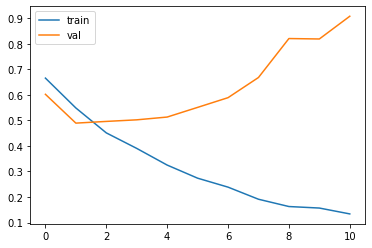

In [23]:
model = Model(hid_feats=50).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-1)
criterion = nn.CrossEntropyLoss()
te = []
val = []
tr = []

for epoch in range(11):
    print('epoch:', epoch)
    model.train()
    running_loss = 0
    for it, (batch_x, batch_y) in enumerate(train_loader):
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        running_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print('training loss:', running_loss/len(train_loader))
    tr.append(running_loss/len(train_loader))
    
    if True:
        val.append(validate(model))


loss_df = pd.DataFrame({'train':tr, 'val':val})
loss_df.plot()

In [26]:
pred = []
label = []
with torch.no_grad():
    for it, (batch_x, batch_y) in enumerate(val_loader):
        logits = model(batch_x)
        
        top_n, top_i = logits.topk(1)
        pred += top_i[:,0].cpu().numpy().tolist()
        label += batch_y.cpu().numpy().tolist()
result_df = pd.DataFrame({'pred':pred, 'label':label})

In [41]:
for _, line in train_df.iterrows():
    if line[3].find(line[1])==-1:
        print(line[1])
        print(line[3])
        print()

electrocute
The Sea Will Electrocute Us All ??

crushed
Crushed

fire
I'm On Fire.  http://t.co/WATsmxYTVa

outbreak
New York City Outbreak: What Is Legionnaire's Disease?   http://t.co/CXI82rFiFS

windstorm
#Insurance: Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/rb02svlpPu

nuclear%20reactor
A 17 year Boy Scout created a mini nuclear reactor in his home

windstorm
Windstorm lastingness perquisite - acquiesce in a twister retreat: ZiUW http://t.co/iRt4kkgsJx

obliterated
Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/QvS7O10bG3

emergency%20services
We're #hiring! Click to apply: RN II/EMERGENCY SERVICES/FT/7P-7A - http://t.co/NV3Uxv9IMX #Nursing #Houston TX http://t.co/ej30IhrEA9

hail
#np Avenged Sevenfold - Hail To The King

mass%20murder
@noah_anyname The utopian impulse inevitably ends in gulags and mass murder.

hijacker
Remove the http://t.co/Xxj2B4JxRt and Linkury Browser Hijacker http://t.co/9gtYlgXrOE http://t.co/yG6Rj8

war%20zone
Sundays during football seasonfrom about 9 am - 11 pm women shouldn't even log onshit be a complete war zone

<unknown>
Three people died from the heat wave so far

suicide%20bomb
Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/IUh718KCy0 http://t.co/9pQyx4xOOL

cyclone
#Camera #Art #Photography http://t.co/TJGxDc3D5p #0215 New BoltåÊCyclone DR PP-400DR Dual Outlet Power PackåÊFor External Camera Flash

$30Û_

detonation
Ignition Knock (Detonation) Sensor Connector-Connecto Dorman 917-141 http://t.co/rfJZexQgxt http://t.co/WQGsmiOiMx

hijacker
Governor Allows Parole for School Bus Hijacker http://t.co/u4bdy1W7d4

sinkhole
Sinkhole swallows Brooklyn intersection ÛÒ video http://t.co/1yBE5mgZL4 http://t.co/7Zog3DpdU9

collapse
Runaway Minion Causes Traffic Collapse in Dublin http://t.co/u2Kwof3wtj

armageddon
Paul Craig Roberts ÛÒ Vladimir Putin Issues Major Warning But Is It Too Late To Escape A http://t.co/NVfKzv5FEx #brics

detonation
Dorman 917-033 Ignition Knock (Detonation) Sensor Connector http://t.co/WxCes39ZTe http://t.co/PyGKSSSCFR

emergency%20services
The #tubestrike is because TFL workers may have trouble planning downtime. I hope none need emergency services. http://t.co/iCSFDSiFqb

avalanche
I HAVE GOT MORE VIDEOS THAN YOU RAPPERS GOT SONGS! http://t.co/pBLvPM6C27

<unknown>
a siren just went off and it wasn't the Forney tornado warning ??

traumatised
WHY THE DEEP ROADS THO HAHAHAHA IM SO TRAUMATISED BY THE DEEP ROADS LOLOL

fatality
Fatality!

debris
What Irony Debris of Flight MH370 found on 'Reunion Island'.

rescuers
VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterran... http://t.co/yvO6q6W442

battle
I added a video to a @YouTube playlist http://t.co/wedWyn9kfS World Of Tanks - Battle Assistant Mod Bat Chat Arti kaboom

bomb
New Documents Found Pointing To Japan's WWII Atomic Bomb Program http://t.co/IucPcSfbMT

crushed
Edwin wow

derailment
CHICAGO FD
STILL &amp; BOX ALARM/EMS PLAN I 
 61ST &amp; CALUMET FOR THE EL TRAIN DERAILMENT
CINS/TG

screaming
@blanksocietyx @emmerdale IM SCREAMING HES MY FAVOURITE

body%20bags
Child Shoulder Bags PVC Shoulder Book Bag Cartoon Cross Body Bags for Girls http://t.co/7l9qAzLjVg http://t.co/Q0hSyfrwEC

armageddon
@KatieKatCubs you already know how this shit goes. World Series or Armageddon.

fatality
@Babybackreeve FATALITY!!!!!!!!!!

upheaval
R'lyeh by Upheaval http://t.co/829n4HJHOL

hellfire
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife

razed
The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/bKsYymvIsg #GN

derailment
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...

detonate
.@no_periferico Apollo Brown - 'Detonate' f. M.O.P. http://t.co/m7na4sKfWR #ORapInforma

blown%20up
On #ThisDayInHistory in

earthquake
Earthquake drill ??

blew%20up
I think I just blew up @HopeInHearts notifications. Go check her out she's so encouraging to me ???? love her ??

flooding
Thankkk U all Soo much for Flooding my NotificationsU my Fella ParShOlics r Superb &amp; Jus soo awesomeLove Love U All always #FrvrGrateful ??

razed
The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/2872J5d4HB

radiation%20emergency
DOE's WIPP facility in NM investigating a site filter radiation reading; has activated its Emergency Ops Center; says no offsite release.

fire%20truck
#SigAlert: North &amp; Southbound 133 closed btwn 5 fwy and Irvine Blvd due to truck fire. CHP is detouring traffic.

body%20bags
Womens Handbags Cross Body Geometric Pattern Satchel Totes Shoulder Bags White http://t.co/qvSp6b2qSU http://t.co/0s6ydFrWDQ RT gasparcÛ_

fatality
I added a video to a @YouTube playlist http://t.co/O7QOgmOegU S@X 109 - SWS | Fatality (Captain Falcon) Vs. Snow (Fox) SSB4 Losers

mas

In [27]:
result_df

,pred,label
0,0,0
1,0,0
2,1,1
3,0,1
4,1,1
...,...,...
1518,0,1
1519,1,1
1520,0,0
1521,1,1


# Ablation 1 - only text

epoch: 0
training loss: 0.6945979278534651
validation loss: 0.6854571203390757
validation accuracy: 0.562048614025116
epoch: 1
training loss: 0.6597588447233041
validation loss: 0.5938046885033449
validation accuracy: 0.7038739323616028
epoch: 2
training loss: 0.4862290828799208
validation loss: 0.4885864282647769
validation accuracy: 0.784635603427887
epoch: 3
training loss: 0.37482201665018994
validation loss: 0.5168288573622704
validation accuracy: 0.7649376392364502
epoch: 4
training loss: 0.3044139784760773
validation loss: 0.5344773990412554
validation accuracy: 0.7669074535369873
epoch: 5
training loss: 0.24264354507128397
validation loss: 0.5709998632470766
validation accuracy: 0.7662508487701416
epoch: 6
training loss: 0.19277698950221142
validation loss: 0.6669606740276018
validation accuracy: 0.760341465473175
epoch: 7
training loss: 0.16372182474394018
validation loss: 0.7352232933044434
validation accuracy: 0.767564058303833
epoch: 8
training loss: 0.12550670952380946
vali

<AxesSubplot:>

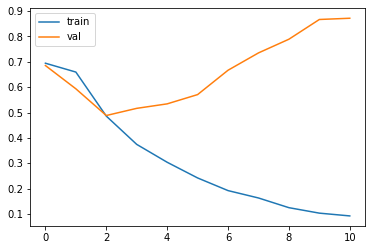

In [9]:
class Model(nn.Module):
    def __init__(self, hid_feats):
        super().__init__()
        
        self.embed_word = nn.Embedding(len(le.classes_), hid_feats)
        
        self.gru = nn.GRU(hid_feats, hid_feats, bidirectional=False, batch_first=True)

        self.linear1 = nn.Linear(hid_feats, hid_feats)
        self.linear2 = nn.Linear(hid_feats, 2)
        
    def forward(self, inputs):
        seq = self.embed_word(inputs[0])
        seq = self.gru(seq)[0][:, -1, :]

        output = self.linear2(seq)
        return output
    
model = Model(hid_feats=50).to('cuda:7')
opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=5e-2)
criterion = nn.CrossEntropyLoss()
te = []
val = []
tr = []

for epoch in range(11):
    print('epoch:', epoch)
    model.train()
    running_loss = 0
    for it, (batch_x, batch_y) in enumerate(train_loader):
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        running_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print('training loss:', running_loss/len(train_loader))
    tr.append(running_loss/len(train_loader))
    
    if True:
        val.append(validate(model))


loss_df = pd.DataFrame({'train':tr, 'val':val})
loss_df.plot()

# Ablation 2 - only keyword

epoch: 0
training loss: 0.662167881305019
validation loss: 0.6395626266797384
validation accuracy: 0.62442547082901
epoch: 1
training loss: 0.5893316005046169
validation loss: 0.5771820992231369
validation accuracy: 0.7045305371284485
epoch: 2
training loss: 0.5406805860499541
validation loss: 0.5621269394954046
validation accuracy: 0.7183191180229187
epoch: 3
training loss: 0.5247980176160733
validation loss: 0.5628212541341782
validation accuracy: 0.7209455370903015
epoch: 4
training loss: 0.5210886262357235
validation loss: 0.5652439706027508
validation accuracy: 0.7261983156204224
epoch: 5
training loss: 0.520356367342174
validation loss: 0.5569866461058458
validation accuracy: 0.7255417108535767
epoch: 6
training loss: 0.519089867050449
validation loss: 0.5600371845066547
validation accuracy: 0.7196323275566101
epoch: 7
training loss: 0.5199558439974984
validation loss: 0.558220931639274
validation accuracy: 0.7242285013198853
epoch: 8
training loss: 0.5176413382093111
validation 

<AxesSubplot:>

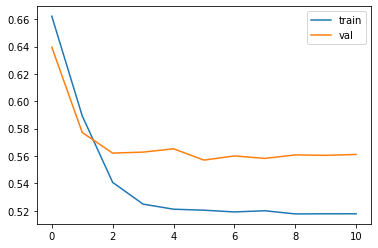

In [10]:
class Model(nn.Module):
    def __init__(self, hid_feats):
        super().__init__()
        
        self.embed_kw = nn.Embedding(len(le_kw.classes_), 8)
        
        self.linear2 = nn.Linear(8, 2)
        
    def forward(self, inputs):
        kw = F.leaky_relu(self.embed_kw(inputs[1]))
        output = self.linear2(kw)
        return output
    
model = Model(hid_feats=50).to('cuda:7')
opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
te = []
val = []
tr = []

for epoch in range(11):
    print('epoch:', epoch)
    model.train()
    running_loss = 0
    for it, (batch_x, batch_y) in enumerate(train_loader):
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        running_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print('training loss:', running_loss/len(train_loader))
    tr.append(running_loss/len(train_loader))
    
    if True:
        val.append(validate(model))


loss_df = pd.DataFrame({'train':tr, 'val':val})
loss_df.plot()

# Ablation 3 - only location

epoch: 0
training loss: 0.68405848244826
validation loss: 0.6840048357844353
validation accuracy: 0.5725541710853577
epoch: 1
training loss: 0.6818067332108816
validation loss: 0.6843529790639877
validation accuracy: 0.5725541710853577
epoch: 2
training loss: 0.6813260608663162
validation loss: 0.6829403763016065
validation accuracy: 0.571897566318512
epoch: 3
training loss: 0.679324875275294
validation loss: 0.682267760237058
validation accuracy: 0.5758371949195862
epoch: 4
training loss: 0.678087285409371
validation loss: 0.6867706875006357
validation accuracy: 0.5758371949195862
epoch: 5
training loss: 0.6786357878396908
validation loss: 0.6816984837253889
validation accuracy: 0.5751805901527405
epoch: 6
training loss: 0.6763655499865612
validation loss: 0.682266948123773
validation accuracy: 0.5751805901527405
epoch: 7
training loss: 0.6761824755618969
validation loss: 0.6828184227148691
validation accuracy: 0.5738673806190491
epoch: 8
training loss: 0.67579042352736
validation los

<AxesSubplot:>

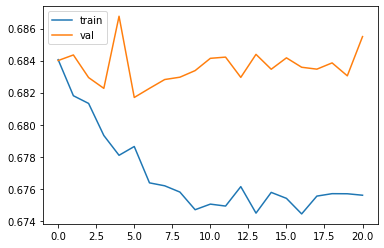

In [11]:
class Model(nn.Module):
    def __init__(self, hid_feats):
        super().__init__()

        self.embed_loc = nn.Embedding(len(le_loc.classes_), 4)
        
        self.linear2 = nn.Linear(4, 2)
        
    def forward(self, inputs):
        loc = F.leaky_relu(self.embed_loc(inputs[2]))
        output = self.linear2(loc)
        return output
    
model = Model(hid_feats=50).to('cuda:7')
opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
te = []
val = []
tr = []

for epoch in range(21):
    print('epoch:', epoch)
    model.train()
    running_loss = 0
    for it, (batch_x, batch_y) in enumerate(train_loader):
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        running_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print('training loss:', running_loss/len(train_loader))
    tr.append(running_loss/len(train_loader))
    
    if True:
        val.append(validate(model))


loss_df = pd.DataFrame({'train':tr, 'val':val})
loss_df.plot()

# Ablation 4 - transformer

epoch: 0
training loss: 0.6777229849249125
validation loss: 0.6429186090826988
validation accuracy: 0.6303348541259766
epoch: 1
training loss: 0.6111925231913725
validation loss: 0.5808400039871534
validation accuracy: 0.7065003514289856
epoch: 2
training loss: 0.5669043796757857
validation loss: 0.5655590817332268
validation accuracy: 0.7170059084892273
epoch: 3
training loss: 0.5465827562535802
validation loss: 0.5669540166854858
validation accuracy: 0.6992777585983276
epoch: 4
training loss: 0.5444546028350791
validation loss: 0.5579056094090143
validation accuracy: 0.7170059084892273
epoch: 5
training loss: 0.5328451513002316
validation loss: 0.5693260667224725
validation accuracy: 0.7137229442596436
epoch: 6
training loss: 0.5357676542674502
validation loss: 0.56477594251434
validation accuracy: 0.7202889323234558
epoch: 7
training loss: 0.5312316625689467
validation loss: 0.5724641717970371
validation accuracy: 0.7137229442596436
epoch: 8
training loss: 0.5341407808785638
validat

<AxesSubplot:>

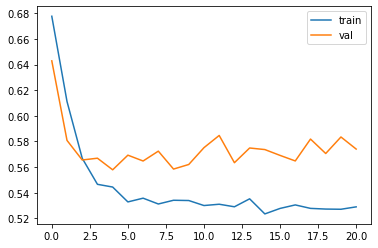

In [12]:
class Model(nn.Module):
    def __init__(self, hid_feats):
        super().__init__()
        
        self.embed_word = nn.Embedding(len(le.classes_), hid_feats)
        self.embed_kw = nn.Embedding(len(le_kw.classes_), 8)
        self.embed_loc = nn.Embedding(len(le_loc.classes_), 2)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hid_feats, nhead=4)
        self.tf_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        
        #self.linear0 = nn.Linear(hid_feats*2, hid_feats)
        self.linear1 = nn.Linear(hid_feats+10, hid_feats)
        self.linear2 = nn.Linear(hid_feats, 2)
        
    def forward(self, inputs):
        seq = self.embed_word(inputs[0])
        seq = torch.transpose(seq, 0, 1)
        kw = self.embed_kw(inputs[1])
        loc = self.embed_loc(inputs[2])
        seq = self.tf_encoder(seq)[0, :, :]
        
        output = F.leaky_relu(F.dropout(self.linear1(torch.cat([kw, loc, seq], 1)), p=0.5, training=self.training))
#         output = seq+loc+kw
        output = self.linear2(output)
        return output
    
model = Model(hid_feats=48).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()
te = []
val = []
tr = []

for epoch in range(21):
    print('epoch:', epoch)
    model.train()
    running_loss = 0
    for it, (batch_x, batch_y) in enumerate(train_loader):
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        running_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print('training loss:', running_loss/len(train_loader))
    tr.append(running_loss/len(train_loader))
    
    if True:
        val.append(validate(model))


loss_df = pd.DataFrame({'train':tr, 'val':val})
loss_df.plot()

epoch: 0
training loss: 0.6894341552009186
validation loss: 0.6839914893110594
validation accuracy: 0.562048614025116
epoch: 1
training loss: 0.6772968408962091
validation loss: 0.6640588815013567
validation accuracy: 0.5896257758140564
epoch: 2
training loss: 0.6367208622395992
validation loss: 0.6075592748820782
validation accuracy: 0.657912015914917
epoch: 3
training loss: 0.5952987705046932
validation loss: 0.5726851485669613
validation accuracy: 0.7012475728988647
epoch: 4
training loss: 0.565842755449315
validation loss: 0.5684149600565434
validation accuracy: 0.7071569561958313
epoch: 5
training loss: 0.5498642744496465
validation loss: 0.5617440988620123
validation accuracy: 0.7117531299591064
epoch: 6
training loss: 0.5403263329838713
validation loss: 0.5571885680158933
validation accuracy: 0.7124097347259521
epoch: 7
training loss: 0.5351056791841984
validation loss: 0.555075836678346
validation accuracy: 0.7242285013198853
epoch: 8
training loss: 0.5299329897388816
validatio

<AxesSubplot:>

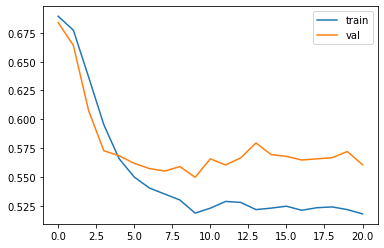

In [13]:
class Model(nn.Module):
    def __init__(self, hid_feats):
        super().__init__()
        
        self.embed_word = nn.Embedding(len(le.classes_), hid_feats)
        self.embed_kw = nn.Embedding(len(le_kw.classes_), 8)
        self.embed_loc = nn.Embedding(len(le_loc.classes_), 2)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hid_feats, nhead=4)
        self.tf_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        #self.linear0 = nn.Linear(hid_feats*2, hid_feats)
        self.linear1 = nn.Linear(hid_feats+10, hid_feats)
        self.linear2 = nn.Linear(hid_feats, 2)
        
    def forward(self, inputs):
        seq = self.embed_word(inputs[0])
        seq = torch.transpose(seq, 0, 1)
        kw = self.embed_kw(inputs[1])
        loc = self.embed_loc(inputs[2])
        seq = self.tf_encoder(seq)[0, :, :]

        output = F.leaky_relu(F.dropout(self.linear1(torch.cat([kw, loc, seq], 1)), p=0.5, training=self.training))
#         output = seq+loc+kw
        output = self.linear2(output)
        return output
    
model = Model(hid_feats=48).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()
te = []
val = []
tr = []

for epoch in range(21):
    print('epoch:', epoch)
    model.train()
    running_loss = 0
    for it, (batch_x, batch_y) in enumerate(train_loader):
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        running_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print('training loss:', running_loss/len(train_loader))
    tr.append(running_loss/len(train_loader))
    
    if True:
        val.append(validate(model))


loss_df = pd.DataFrame({'train':tr, 'val':val})
loss_df.plot()